# Feature Engineering through Eigen-Vesting with Random Matrix Filtering

In this notebook, we examine the underlying graphical structure of the S&P500 through feature engineering and random matrix filtering. With features computed for an $n$-stock by $n$-stock correlation matrix we can gather the necessary information to be able to classify the current trend of the market. Such features include correlation dispersion, variance explained by top $n$ eigenvalues of the correlation matrix, and correlation sensitivity. In order to compute a necessary training dataset for a classifier to determine which regime we are currently examining, we must first sample an appropriate number of correlation matrices from historical data, label the regime based off of the sharpe ratio of that time period, and compute its graphical features which we detail below. This results in a supervised learning problem that a classifier can easily tackle, and can be put towards tweaking algorithmic trading strategies based off of the current regime conditions.

In [ ]:
import cvxpy as cp
import cvxopt as opt
from cvxopt import blas, solvers
import dask.dataframe as dd
import numpy as np
import pandas as pd
import datetime
import sif_utils as su
import matplotlib.pyplot as plt

import sys
from random import randint
import fastcluster
from scipy.cluster import hierarchy
from scipy.stats import rankdata
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import cophenet
import warnings
warnings.filterwarnings('ignore')

In [ ]:
start_date = datetime.datetime(2007, 1, 1)
end_date = datetime.datetime(2020, 1, 1)
all_dates = su.get_trading_days(start_date, end_date)

top_n = 500

tickers = sorted(su.get_universe_tickers(top_n, start_date, end_date))
universe_size = len(tickers)
price_attrs = ['open', 'close']
df = su.get_equity_data(tickers, start_date, end_date, price_attrs)['close']

In [ ]:
returns = df
dim = 500
tri_a, tri_b = np.triu_indices(dim, k=1)

### Sample 300 year-long Correlation Matrices from historical data and categorize market regime

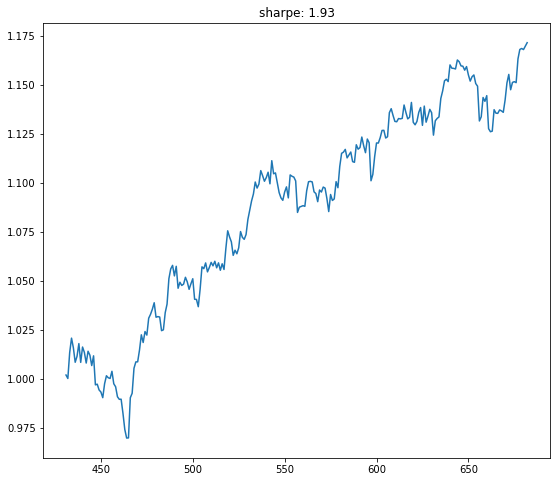

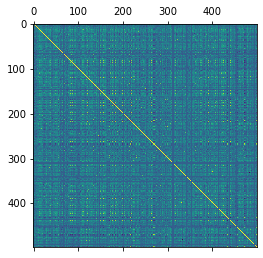

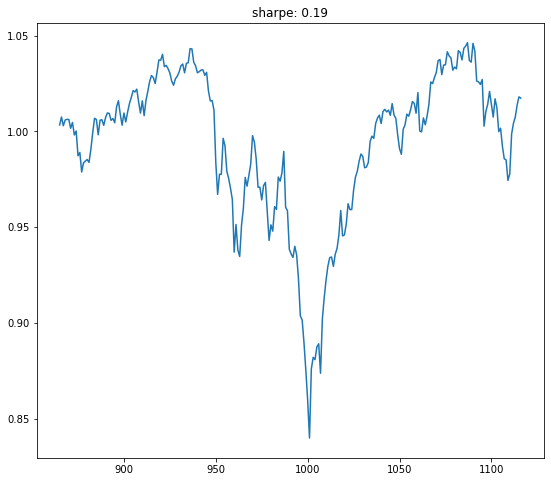

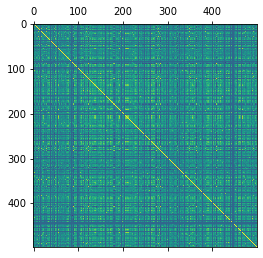

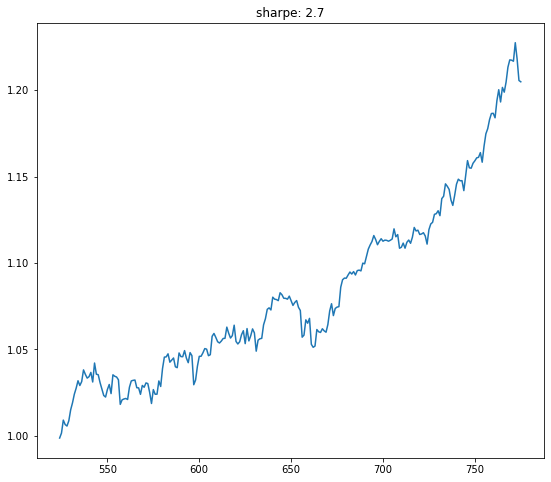

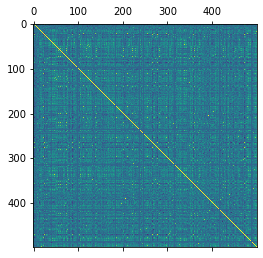

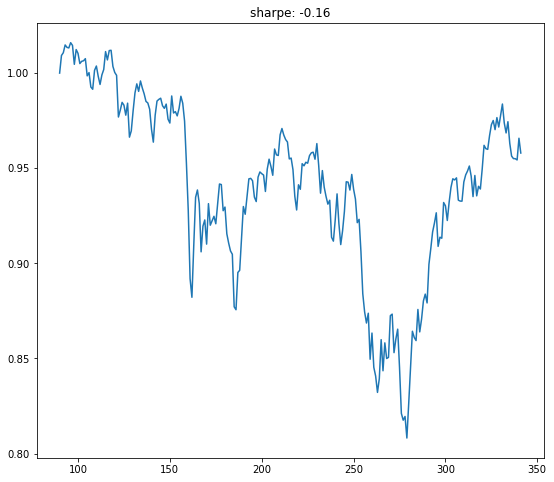

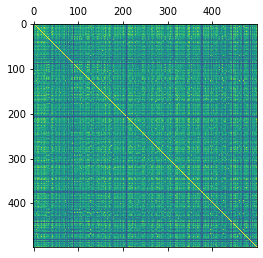

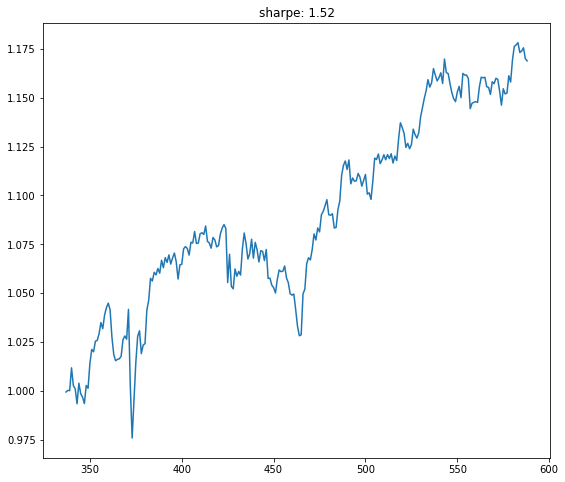

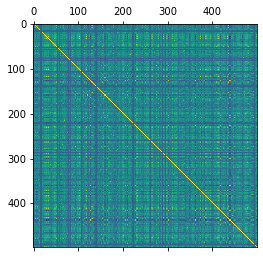

In [ ]:
corr_vs_sharpe = []
stressed_mats = []
stressed_count = 0
rally_mats = []
rally_count = 0
normal_mats = []
normal_count = 0
for loop in range(300):
    try:
        t_idx = randint(0, len(returns) - 252)

        period_returns = returns.iloc[t_idx:(t_idx + 252)]

        rmv = 0
        for col in period_returns.columns:
            if len(period_returns[col].dropna()) < 252:
                rmv += 1
                del period_returns[col]

        idx = list(np.random.choice(len(period_returns.columns), dim,
                                    replace=False))

        period_returns[period_returns.columns[idx]].dropna().shape
        corr = period_returns[
            period_returns.columns[idx]].dropna().corr().values
        temp = corr
        corr[np.isnan(corr)] = 0

        mean_return = (period_returns[period_returns.columns[idx]]
                       .dropna()
                       .mean(axis=1)
                       .mean() * 252)
        vol = (period_returns[period_returns.columns[idx]]
               .dropna()
               .mean(axis=1)
               .std() * np.sqrt(252))
        sharpe = mean_return / vol


        corr_vs_sharpe.append([corr.mean(), sharpe])
        if sharpe < -0.5:
            stressed_mats.append(corr)
            #np.save('stressed_mats/mat_{}.npy'.format(stressed_count), corr)
            stressed_count += 1
        elif sharpe > 2:
            rally_mats.append(corr)
            #np.save('rally_mats/mat_{}.npy'.format(rally_count), corr)
            rally_count += 1
        else:
            normal_mats.append(corr)
            #np.save('normal_mats/mat_{}.npy'.format(normal_count), corr)
            normal_count += 1

        if loop < 5:
            plt.figure(figsize=(20, 8))
            plt.subplot(1, 2, 1)
            plt.plot((1 + period_returns[
                period_returns.columns[idx]]
                      .dropna().mean(axis=1)).cumprod())
            plt.title("sharpe: " + str(np.round(sharpe, 2)))

            plt.matshow(temp)
            plt.show()
    except:
        pass

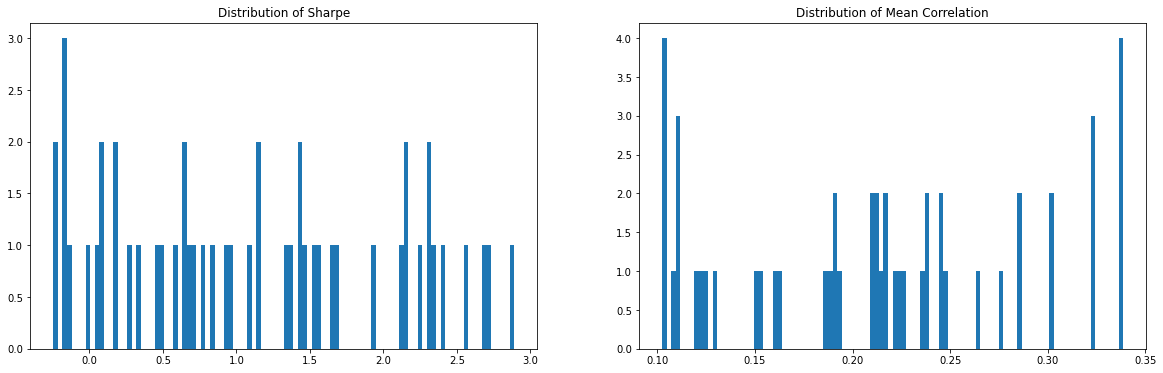

In [ ]:
corr_vs_sharpe = np.array(corr_vs_sharpe)

plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.hist(corr_vs_sharpe[:, 1], bins=100)
plt.title('Distribution of Sharpe')

plt.subplot(1, 2, 2)
plt.hist(corr_vs_sharpe[:, 0], bins=100)
plt.title('Distribution of Mean Correlation')
plt.show()

### Create distributions of stressed, rally, and normal correlation coefficients to plot spread 
Plotting and data wrangling takes a very long time and a lot of memory. Consider subsampling the coefficients down to a reasonable number.

In [ ]:
stressed_corr_coeffs = []
rally_corr_coeffs = []
normal_corr_coeffs = []
for mat in stressed_mats:
    stressed_corr_coeffs.extend(list(mat[tri_a]))
for mat in rally_mats:
    rally_corr_coeffs.extend(list(mat[tri_a]))
for mat in normal_mats[1:30]:
    normal_corr_coeffs.extend(list(mat[tri_a]))

In [ ]:
nbins = 100
plt.figure(figsize=(15, 6))
plt.hist(normal_corr_coeffs[1:400], bins=nbins, alpha=1,
         label='normal: -0.5 <= sharpe <= 2',
         density=True, log=False)
plt.axvline(x=np.mean(normal_corr_coeffs[1:400]), color='b',
            linestyle='dashed', linewidth=2)
plt.hist(stressed_corr_coeffs, bins=nbins, alpha=0.8,
         label='stressed: sharpe < -0.5',
         density=True, log=False)
plt.axvline(x=np.mean(stressed_corr_coeffs[1:400]), color='r',
            linestyle='dashed', linewidth=2)
plt.hist(rally_corr_coeffs, bins=nbins, alpha=0.6,
         label='rally: 2 < sharpe',
         density=True, log=False)
plt.axvline(x=np.mean(rally_corr_coeffs[1:400]), color='g',
            linestyle='dashed', linewidth=2)
plt.legend()
plt.show()

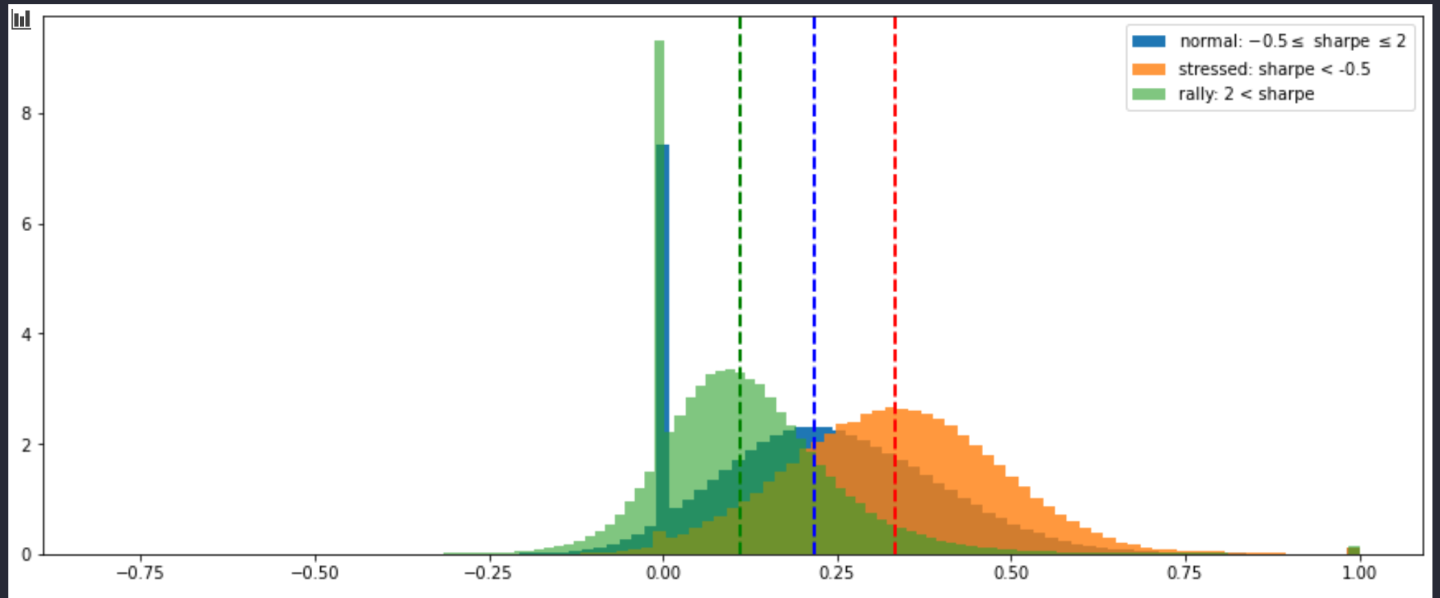

In [ ]:
from IPython.display import Image
Image("market_regime_vs._dist_of_correlation_coeffs.png")

### Eigen-Vesting
1) Correlation coefficient quantiles (1,10,90,99)%

2) Variance explained by top (1,5,30) eigenvalues of the correlation matrix

3) Variance explained by eigenvalues falling within Marchenko-Pastur distribution

#### Marchenko-Pastur Distribution
Found in research paper on sample covariance matrices: [Local Marchenko-Pastur law at the hard edge of sample covariance matrices, Journal of Mathematical Phsyics](https://arxiv.org/pdf/1206.1730.pdf)

We can use the Marchenko-Pastur to filter eigenvalues out that are only due to randomness and therefore result in a more accurate trend model of correlations.

4) Determinant of Correlation matrix: the correlation volume decreases as the determinant approaches 1 and increases as the latter approaches 0. This is the opposite of ordinary correlation coefficients, in which higher numbers indicate greater positive correlation. The determinant of the correlation matrix will equal 1 only if all correlations equal 0, otherwise the determinant will be less than 1. Remember that the determinant is related to the volume of the space occupied by the swarm of data points represented by standard scores on the measures involved. When the measures are uncorrelated, this space is a sphere with a volume of 1.

5) Condition Number of Correlation Matrix: In the field of numerical analysis, the condition number of a function measures how much the output value of the function can change for a small change in the input argument. This is used to measure how sensitive a function is to changes or errors in the input, and how much error in the output results from an error in the input, in addition to how sensitive a linear system's solution is to a miniscule change in input.

6) Quantile statistics on eigenvalues

7) Minimum Spanning Tree (MST) statistics of correlation distance graph structure

8) 4 Different Linkage algorithms imposed on a hierarchical clustering of the correlation matrix and the cophenetic correlation (preservation of dendogram structure) of each linkage algorithm

Resources used: [Cluster analysis on the structure of the cryptocurrency market via Bitcoin–Ethereum filtering, Song et al. 2019](https://www.sciencedirect.com/science/article/abs/pii/S0378437119304893), [Random Matrix Theory Notes by Alan Edelman](https://web.eecs.umich.edu/~rajnrao/Acta05rmt.pdf)

In [ ]:
import networkx as nx
def compute_mst_stats(corr):
    dist = (1 - corr) / 2
    G = nx.from_numpy_matrix(dist) 
    mst = nx.minimum_spanning_tree(G)

    features = pd.Series()
    features['mst_avg_shortest'] = nx.average_shortest_path_length(mst)


    closeness_centrality = pd.Series(list(nx.closeness_centrality(mst).values())).describe()
    for stat in closeness_centrality.index[1:]:
        features[f'mst_centrality_{stat}'] = closeness_centrality[stat]

    return features

def compute_features_from_correl(model_corr):
    n = model_corr.shape[0]
    a, b = np.triu_indices(n, k=1)
    
    features = pd.Series()
    coefficients = model_corr[a, b].flatten()

    coeffs = pd.Series(coefficients)
    coeffs_stats = coeffs.describe()
    for stat in coeffs_stats.index[1:]:
        features[f'coeffs_{stat}'] = coeffs_stats[stat]
        
    features['coeffs_1%'] = coeffs.quantile(q=0.01)
    features['coeffs_10%'] = coeffs.quantile(q=0.1)
    features['coeffs_90%'] = coeffs.quantile(q=0.9)
    features['coeffs_99%'] = coeffs.quantile(q=0.99)


    # eigenvalues and eigenvectors
    eigenvals, eigenvecs = np.linalg.eig(model_corr)
    permutation = np.argsort(eigenvals)[::-1]
    eigenvals = eigenvals[permutation]
    eigenvecs = eigenvecs[:, permutation]

    pf_vector = eigenvecs[:, np.argmax(eigenvals)]
    if len(pf_vector[pf_vector < 0]) > len(pf_vector[pf_vector > 0]):
        pf_vector = -pf_vector

    features['varex_eig1'] = float(eigenvals[0] / sum(eigenvals))
    features['varex_eig_top5'] = (float(sum(eigenvals[:5])) / float(sum(eigenvals)))
    features['varex_eig_top30'] = (float(sum(eigenvals[:30])) / float(sum(eigenvals)))
    
    # Marcenko-Pastur -- describes the asymptotic behavior of singular values of large rectangular random matrices (stock data!)
    T, N = 252, n
    MP_cutoff = (1 + np.sqrt(N / T))**2
    
    # variance explained by eigenvals outside of the MP distribution
    features['varex_eig_MP'] = (float(sum([e for e in eigenvals if e > MP_cutoff])) / float(sum(eigenvals)))
    
    # determinant of the matrix = product of eigenvalues of a matrix
    features['determinant'] = np.prod(eigenvals)
    
  
    features['condition_number'] = abs(eigenvals[0]) / abs(eigenvals[-1])


    # stats of the first eigenvector entries
    pf_stats = pd.Series(pf_vector).describe()
    if pf_stats['mean'] < 1e-5:
        return None
    for stat in pf_stats.index[1:]:
        features[f'pf_{stat}'] = float(pf_stats[stat])


    # stats on the MST
    features = pd.concat([features, compute_mst_stats(model_corr)],axis=0)

    # stats on the linkage -- measures of how faithfully a dendrogram preserves the pairwise distances between the original unmodeled data points
    dist = np.sqrt(2 * (1 - model_corr))
    for algo in ['ward', 'single', 'complete', 'average']:
        Z = fastcluster.linkage(dist[a, b], method=algo)
        features[f'coph_corr_{algo}'] = cophenet(Z, dist[a, b])[0]

    return features.sort_index()

### Quick Comparison of Filtered vs. Unfiltered Correlation Matrix MinVar Portfolio Returns

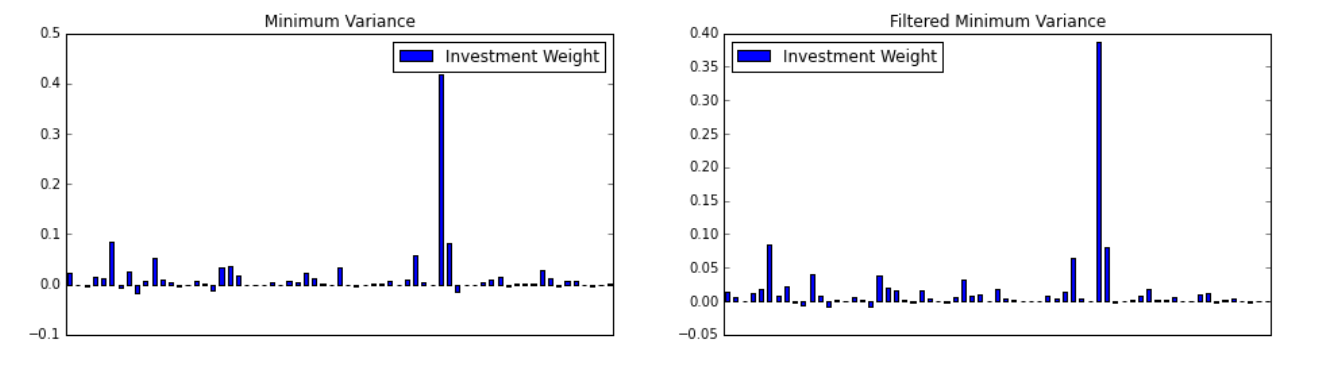

In [ ]:
from IPython.display import Image
Image("filter_weights.png")

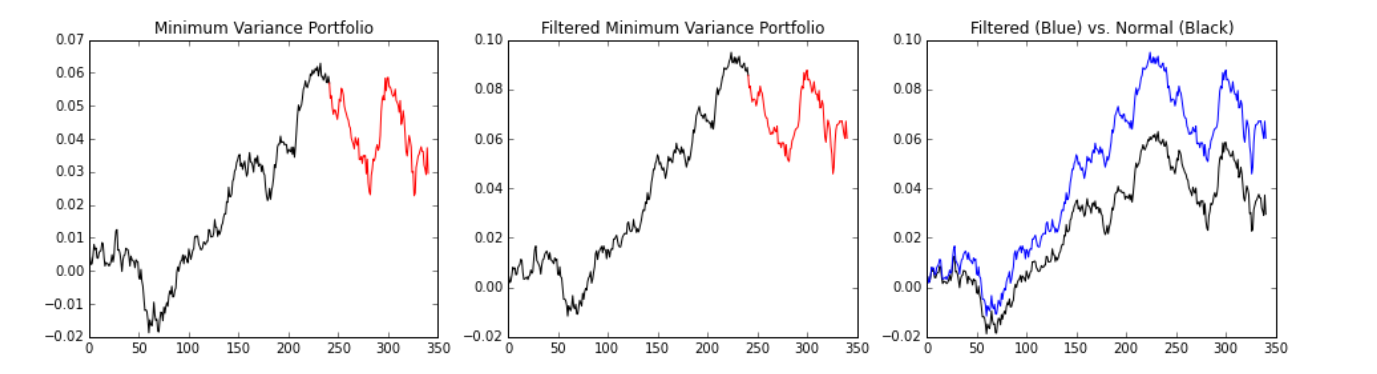

In [ ]:
from IPython.display import Image
Image("filter_returns.png")

### Load computed regime features for 2010-2020
Done by calling compute_features_from_correl on every correlation matrix sampled above, takes a very long time to compute (1-2 hours)

In [ ]:
feature_regimes = pd.read_csv('regime_features.csv')
feature_regimes = feature_regimes.astype(str)
for col in feature_regimes.columns:
    feature_regimes[col] = [complex(x.replace(")","").replace("(","")).real for x in feature_regimes[col]]
dummies = feature_regimes[['stressed', 'rally', 'normal']]
feature_regimes['target'] = pd.Series(dummies.columns[np.where(dummies!=0)[1]])
print(feature_regimes.shape)
feature_regimes.head()

(300, 41)


,Unnamed: 0,coeffs_1%,coeffs_10%,coeffs_25%,coeffs_50%,coeffs_75%,coeffs_90%,coeffs_99%,coeffs_max,coeffs_mean,...,pf_min,pf_std,varex_eig1,varex_eig_MP,varex_eig_top30,varex_eig_top5,stressed,rally,normal,target
0,0.0,-0.013148,0.0,0.151614,0.287790,0.401552,0.497987,0.669259,1.0,0.276563,...,-0.002713,0.016323,0.340973,0.482395,0.655938,0.469845,1.0,0.0,0.0,stressed
1,1.0,-0.012532,0.0,0.138356,0.264486,0.370656,0.460677,0.648629,1.0,0.256303,...,-0.000332,0.016036,0.312882,0.444616,0.631866,0.444616,1.0,0.0,0.0,stressed
2,2.0,-0.023035,0.0,0.129902,0.263690,0.380503,0.479691,0.653082,1.0,0.258670,...,-0.001131,0.016775,0.320350,0.462056,0.638924,0.449659,1.0,0.0,0.0,stressed
3,3.0,0.000000,0.0,0.163489,0.303171,0.413001,0.503652,0.659962,1.0,0.284976,...,-0.002946,0.016296,0.354946,0.503735,0.663541,0.477268,1.0,0.0,0.0,stressed
4,4.0,-0.004801,0.0,0.149078,0.289232,0.408707,0.505597,0.667852,1.0,0.278405,...,-0.001157,0.016648,0.347615,0.485614,0.659748,0.472187,1.0,0.0,0.0,stressed


### Mini Data Science / ML Pipeline for Market Regime Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=42)

In [ ]:
y = feature_regimes['target']
X = feature_regimes.drop(['target', 'rally', 'normal', 'stressed', 'Unnamed: 0'], axis=1)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 13)

In [ ]:
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### SHAP Contribution Plots of feature importances train vs. whole dataset

In [ ]:
import shap
def display_shap_importance(X, X_train):
    height = 10
    width = 20
    plt.figure(figsize=(height, width))
    plt.subplot(1, 2, 1)
    # shap on the whole dataset
    explainer = shap.TreeExplainer(clf)
    shap_values = explainer.shap_values(X, approximate=True)
    shap.summary_plot(shap_values, X,
                      color_bar=False,
                      class_names=['normal', 'rally', 'stressed'],
                      plot_size=(width, height), show=False)
    plt.title(f'Whole dataset')
    plt.subplot(1, 2, 2)
    # shap on the train dataset
    explainer = shap.TreeExplainer(clf)
    shap_values = explainer.shap_values(X_train, approximate=True)
    shap.summary_plot(shap_values, X_train,
                      color_bar=False,
                      class_names=['normal', 'rally', 'stressed'],
                      plot_size=(width, height), show=False)
    plt.title(f'Train dataset')
    plt.show()

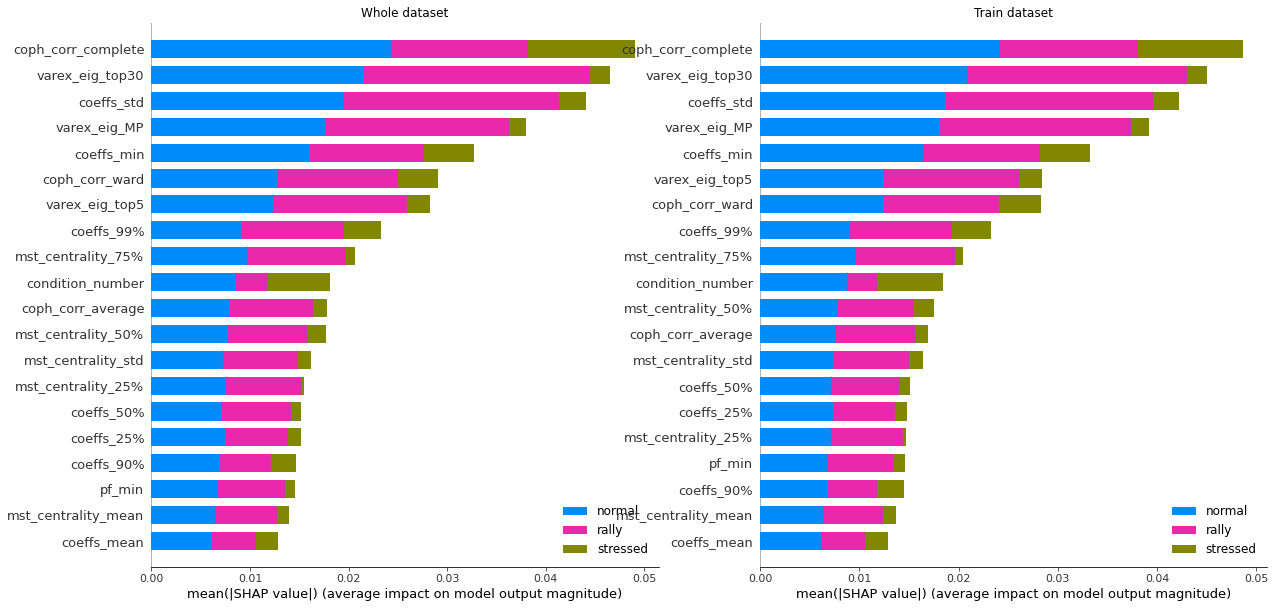

In [ ]:
display_shap_importance(X,X_train)

### SHAP Force-Plots of feature importances

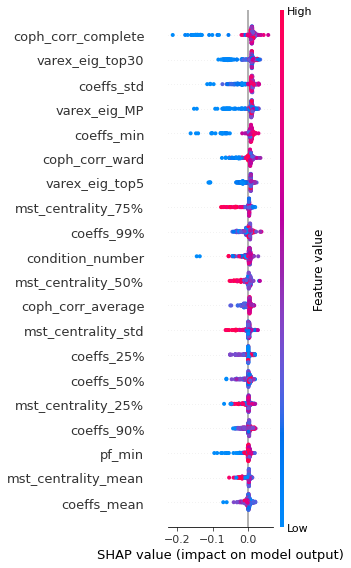

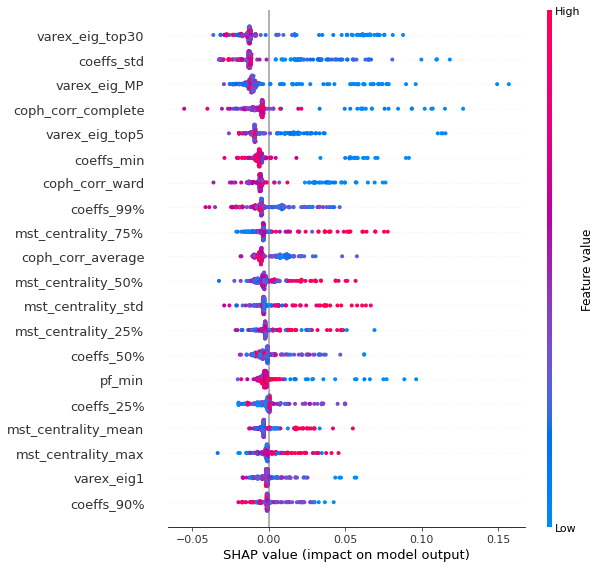

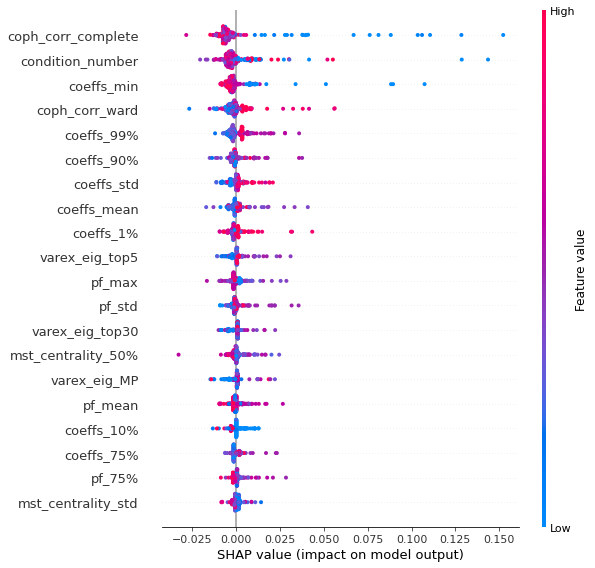

In [ ]:
height = 12
width = 20
plt.figure(figsize=(height, width))
plt.subplot(1, 3, 1)
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_train, approximate=True)
for i in range(0,3):
    shap.summary_plot(shap_values[i], X_train)
plt.show()

### Optimization Script for Switch Trading Algorithm based on Sci-Kit Learn Market Regime Classifier
Switch happens along same time interval at which the classifier features were sampled (i.e. sample a correlation matrix every 5 days, compute features, re-train classifier, switch in strategy happens every 5 days)

In [ ]:
import cvxopt as opt
from cvxopt import blas, solvers
solvers.options['show_progress'] = False

def optimal_portfolio(returns, switch, target_return, market_return):
    '''
    Pass in pandas dataframe of daily returns (row=date sample, column = ticker), switch = 'stressed' || 'rally' || 'neutral' passed from scikit result, target_return is mean return of universe, market_return is market return
    '''
    n = len(returns.T)
    N = 10000
    
    # Generate scale of expected values to optimize on
    mus = [10**(6.0 * t/N - 1.0) for t in range(N)]

    # Convert fixed matrices to cvxopt matrices
    S = opt.matrix(np.cov(returns.T))
    pbar = opt.matrix(np.mean(returns))

    # Create constraint matrices  
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Strategy switch operation
    if switch == 'rally':
        G = -opt.matrix(np.eye(n))
        h = opt.matrix(0.0, (n ,1))
    elif switch == 'neutral':
        G = opt.matrix(-returns.values).T
        h = opt.matrix(-market_return)
    elif switch == 'stressed':
        G = opt.matrix(-returns.values).T
        h = opt.matrix(-target_return)

    # Calculate efficient frontier weights using quadratic programming solver
    portfolios = [solvers.qp(mu * S, -pbar, G, h, A, b)['x'] 
                  for mu in mus]
    ## Risks and returns
    returns = [blas.dot(pbar, x)*252 for x in portfolios]
    risks = [np.sqrt(blas.dot(x.trans(), S * x)) * np.sqrt(252) for x in portfolios]
    
    ## Calculate 2nd degree polynomial of frontier curve
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    
    # Calculate optimal sharpe ratio allocations
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']

    return returns, risks, m1, x1, wt

### Moving Forward

In the future I would like to distribute the regimes in a more granular fashion, rather than a -1, 0, 1 method. Below is an image that I would like to extend my research towards, in which we categorize micro-regimes and create trend based switching on a larger array of trends rather than just 3.

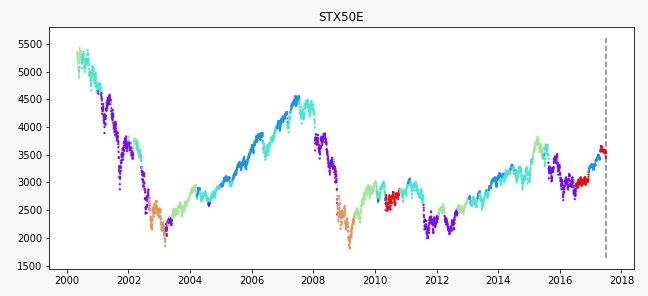

In [ ]:
from IPython.display import Image
Image("stx_dymas_unknown_regimes.png")